In [1]:
import numpy as np
import pandas as pd
import polars as pl 
import polars_ols as pls

import glob
import os

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from scipy.optimize import curve_fit

sns.set_theme(context="poster", style="white")

In [2]:
import zipfile

def unzip_and_rename_csv(zip_file_path, extract_to_folder=None, renamed_csv="latest_od_data.csv"):
    """
    Unzips a file containing one CSV and renames it to a specified name.

    Args:
        zip_file_path (str): Path to the zip file.
        extract_to_folder (str): Folder where files should be extracted.
                                 Defaults to the same directory as the zip file.
        renamed_csv (str): Desired name for the extracted CSV file.

    Returns:
        str: Path to the renamed CSV file.
    """
    if extract_to_folder is None:
        extract_to_folder = os.path.dirname(zip_file_path)
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all files
        zip_ref.extractall(extract_to_folder)
        
        # Identify the extracted CSV file
        csv_file = None
        for file_name in zip_ref.namelist():
            if file_name.lower().endswith('.csv'):
                csv_file = os.path.join(extract_to_folder, file_name)
                break
        
    # Check if a CSV file was found
    if csv_file is None:
        raise FileNotFoundError("No CSV file found in the ZIP archive.")
    
    # Rename the CSV file
    renamed_csv_path = os.path.join(extract_to_folder, renamed_csv)
    os.rename(csv_file, renamed_csv_path)
    
    return renamed_csv_path


# Exp 1
exp1 = unzip_and_rename_csv('./od_logs/exp1.zip', renamed_csv="exp1.csv")


# Get the list of CSV files in the Downloads folder
csv_files = glob.glob(os.path.expanduser('~/Downloads/*.csv'))

if len(csv_files) == 0:
    latest_csv = unzip_and_rename_csv('./od_logs/latest_od_data.zip')
else:
    # Find the most recent file based on modification time
    latest_csv = max(csv_files, key=os.path.getmtime)

In [3]:
# Load the latest CSV file
exp1 = pl.scan_csv(exp1).select("od_reading", "timestamp_localtime", "pioreactor_unit").rename({"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})
df = pl.scan_csv(latest_csv).select("od_reading", "timestamp_localtime", "pioreactor_unit").rename({"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})
df = pl.concat([df, exp1])
# If you want to load a specific CSV file, you can use the following line:
# df = pl.scan_csv(insert csv here).select("OD600", "Time", "Unit")

# Dictionary to map 'Pioreactor name' to new values
name_dict = {
    #'worker 1': 'W1  - Replicate 3',
    'worker2': 'W2 - 35 ppt Control',
    'worker3': 'W3 - Replicate 1',
    'worker4': 'W4 - Replicate 2',
    'worker5': 'W5 - 55 ppt Control'
}

optimal_controls = ["W2 - 35 ppt Control"]
stressed_controls = ["W5 - 55 ppt Control"]
controls = ["W5 - 55 ppt Control", "W2 - 35 ppt Control"]
replicates = ["W3 - Replicate 1", "W4 - Replicate 2"]

# Define the corresponding transformations for each condition
equations = {
    #'W1  - Replicate 3': (0, 0),  # Not defined
    "W2 - 35 ppt Control": (1.348628103, 0.077), 
    "W3 - Replicate 1": (2.073660771, .077), 
    "W4 - Replicate 2": (2.204291876, .077), 
    "W5 - 55 ppt Control": (1.169484467, .077), 
}

threshold_od = 0.24  # Point after which we subculture

# Replace values in 'Pioreactor name' column using the dictionary
df = df.with_columns(pl.col("Unit").replace_strict(name_dict))

# Apply the equation
a = pl.col("Unit").replace_strict(equations).list.first()
b = pl.col("Unit").replace_strict(equations).list.last()
df = df.with_columns((pl.col("OD600") * a + b))

# Convert 'timestamp_localtime' to datetime format
df = df.with_columns(pl.col("Time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))

# Filter subculture artifacts
df = df.filter(pl.col("Time") >= pl.col("Time").min().dt.offset_by("5m"))

# Filter out artifact
df= df.with_columns((pl.col("Time").sub(pl.col("Time").min()).dt.total_seconds()/3600).alias("Hours"))
df = df.filter((pl.col("Unit").eq("W5 - 55 ppt Control") & pl.col("Hours").ge(104.2) &  pl.col("Hours").le(104.4)).not_())

df = df.sort("Unit", "Hours")

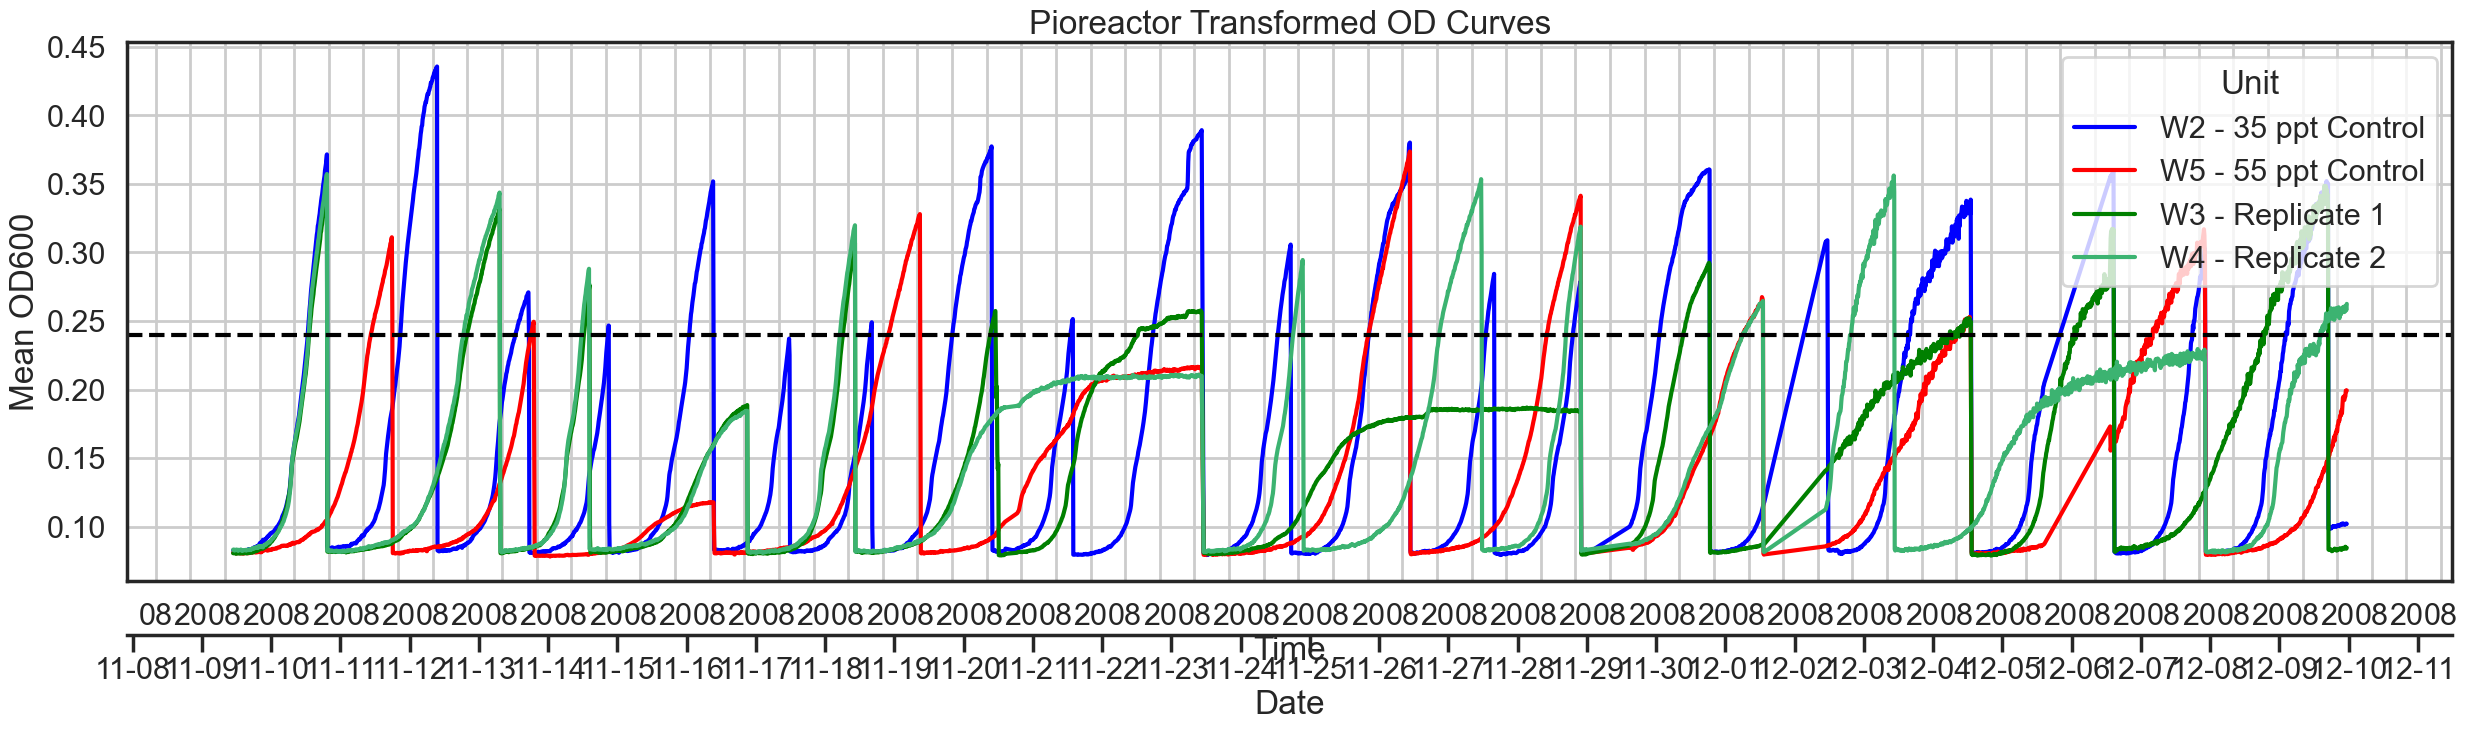

In [4]:
# Take a rolling average in each step
plot_df = df.with_columns(pl.col("Time").dt.truncate("10m").alias("Time"))
plot_df = plot_df.group_by("Unit", "Time").agg(pl.col("OD600").mean().alias("Mean OD600"))
plot_df = plot_df.with_columns((pl.col("Time").sub(pl.col("Time").min()).dt.total_seconds()/3600).alias("Hours"))

# Plotting the growth curves
hue_order = ["W2 - 35 ppt Control", "W5 - 55 ppt Control", "W3 - Replicate 1", "W4 - Replicate 2"]

f, ax = plt.subplots(figsize=(30, 7))
sns.lineplot(data=plot_df.collect(streaming=True).to_pandas(), x="Time", y="Mean OD600", hue="Unit", hue_order=hue_order, markersize=8, 
             sizes=(1, 8), ax=ax, palette=["blue", "red", "green", "mediumseagreen"])

plt.axhline(y=threshold_od, color='black', linestyle='--')
# Set major ticks to every 6 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.set_xlabel("Time")

# Create a secondary x-axis for date display
secax = ax.secondary_xaxis(-0.1)
secax.xaxis.set_major_locator(mdates.DayLocator())
secax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
secax.set_xlabel("Date")
ax.set_title('Pioreactor Transformed OD Curves')
plt.grid(True)
plt.show()

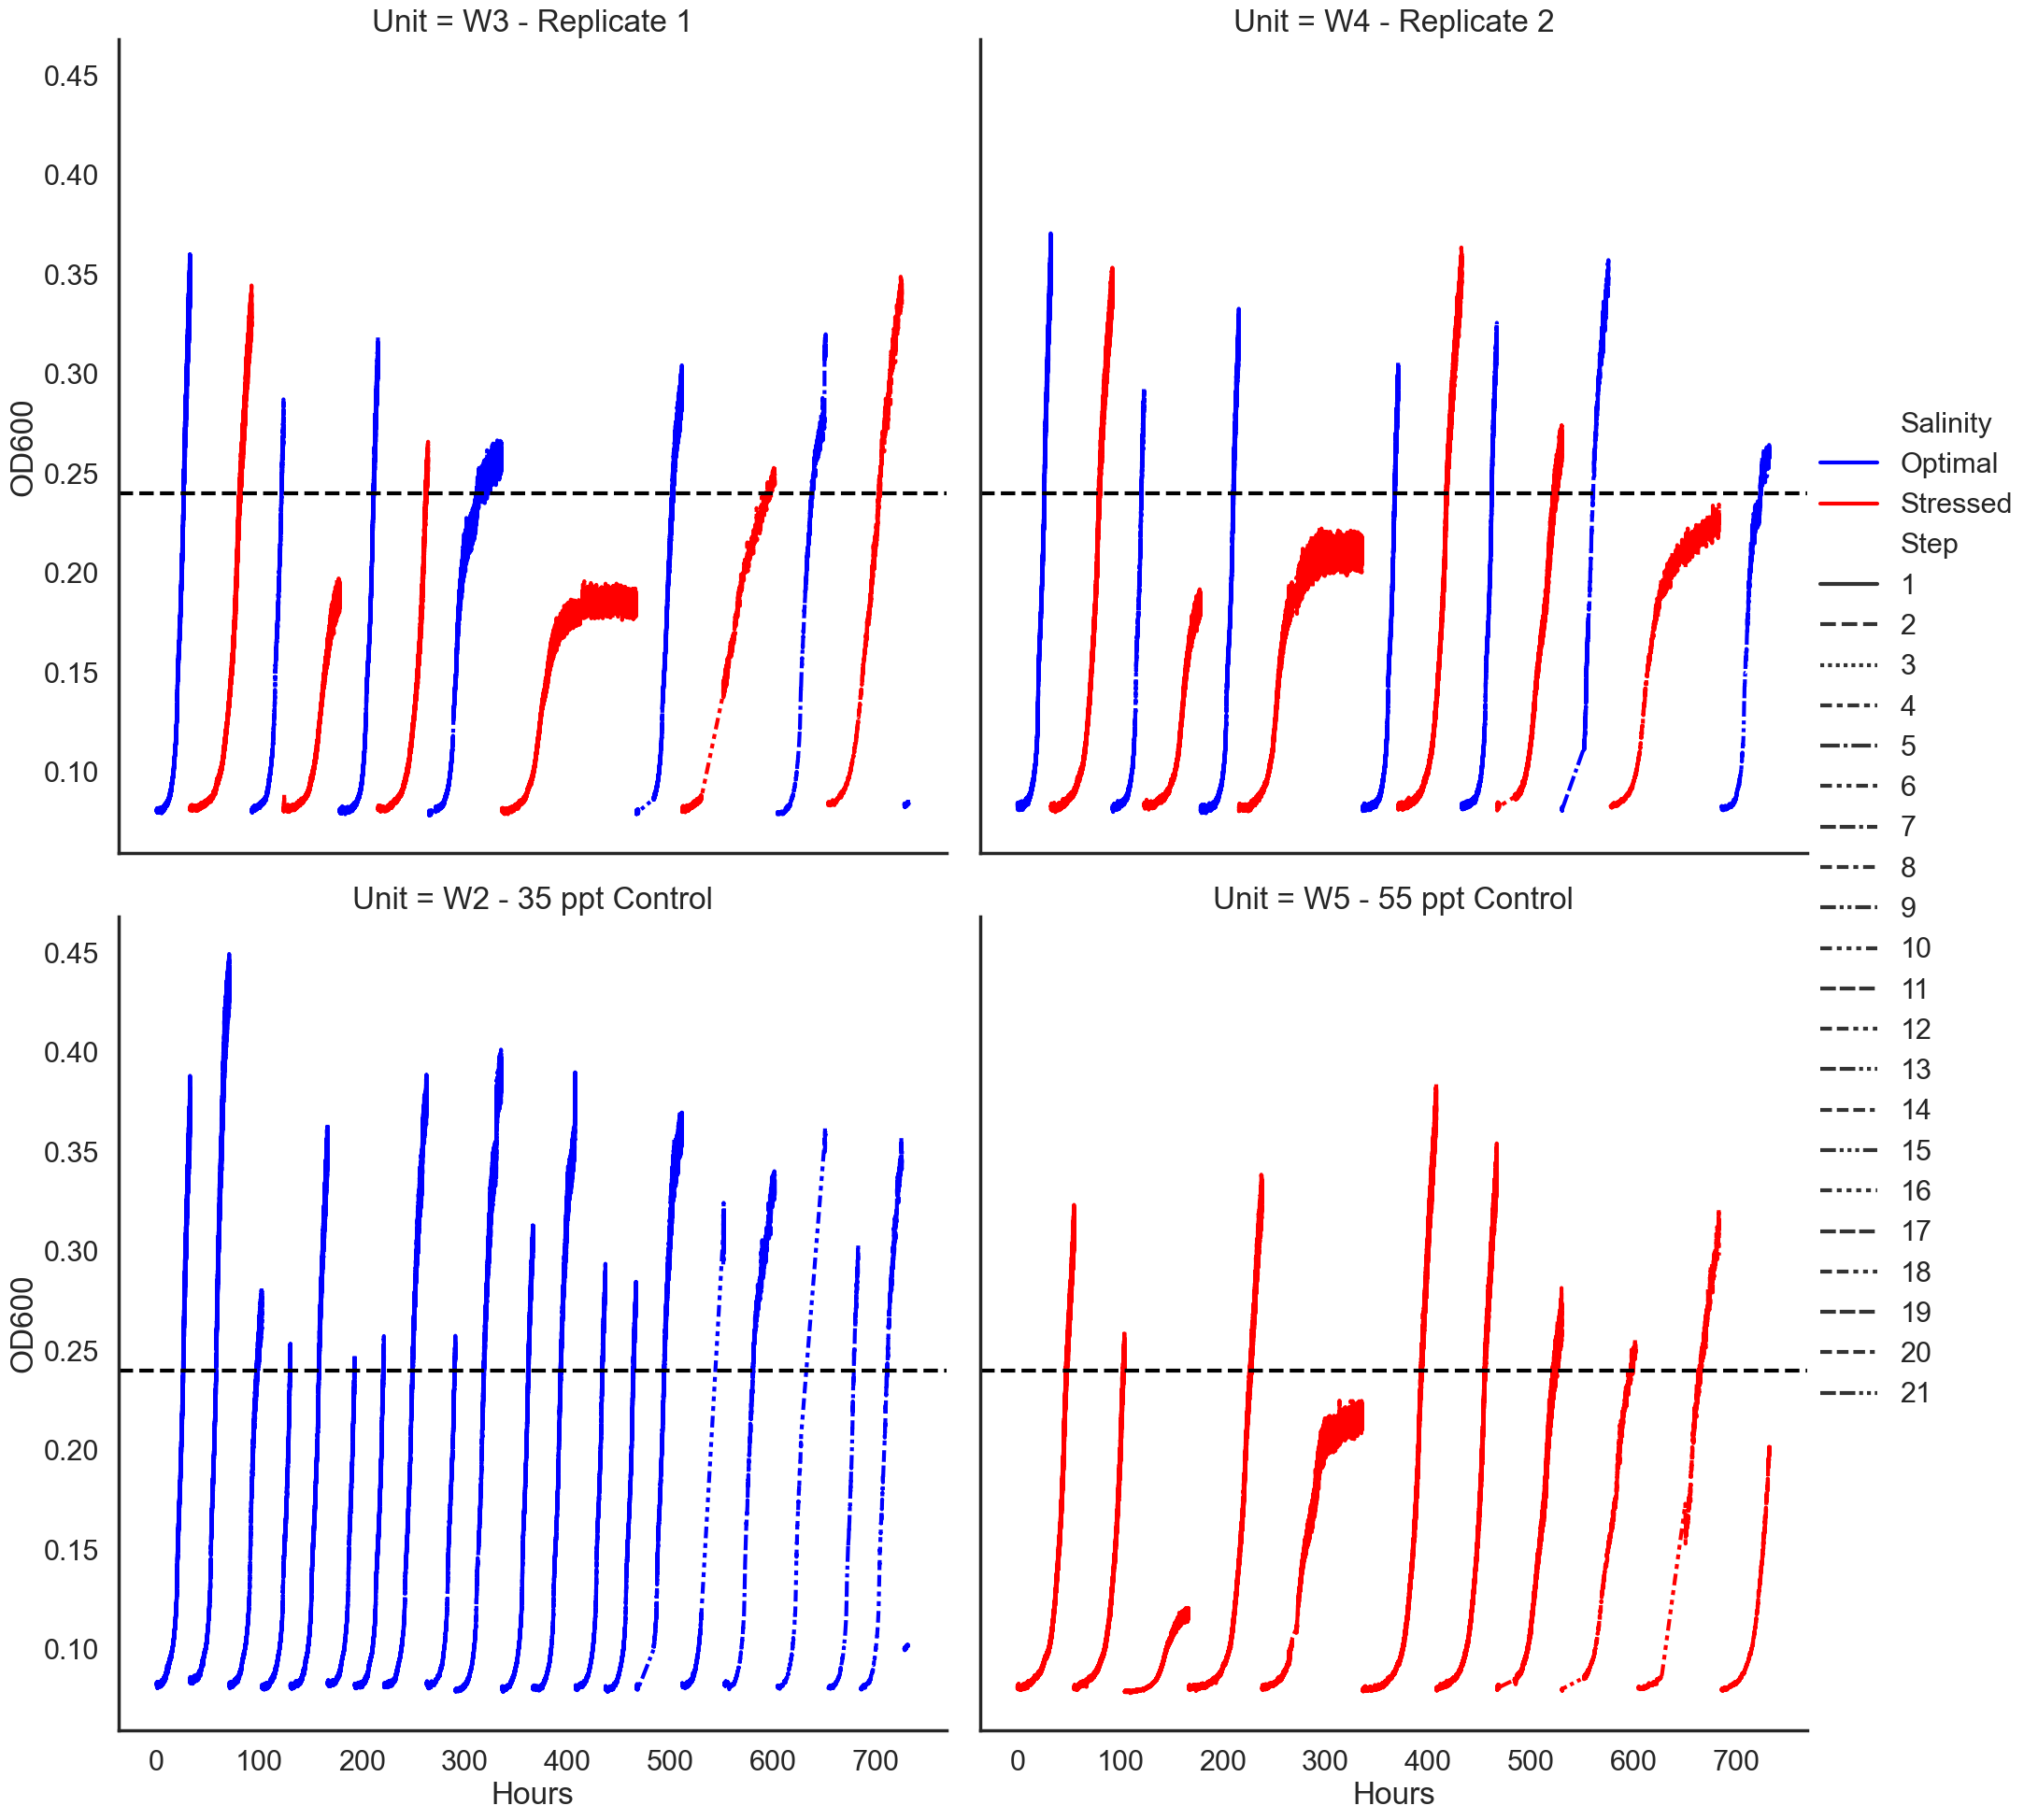

In [5]:
# def find_steps(class_df, shift):
#     # Condition for incrementing 'step'
#     class_df = class_df.sort("Unit", "Hours")
#     step_cond = (pl.col("OD600").shift(shift) - pl.col("OD600") > 0.03)
    
#     # Use cumulative sum over the 'step_condition' to increment each time it's True
#     class_df = class_df.with_columns(pl.when(step_cond).then(1).otherwise(0).cum_sum().add(1).over(pl.col("Unit")).alias("Step"))
    
#     # Add condition to the df
#     class_df = class_df.with_columns(pl.when((pl.col("Step") % 2 == 1) & (pl.col("Unit").is_in(replicates)))
#                          .then(pl.lit("Optimal"))
#                          .otherwise(pl.when((pl.col("Step") % 2 == 0) & (pl.col("Unit").is_in(replicates)))
#                                     .then(pl.lit("Stressed"))
#                                     .otherwise(pl.when(pl.col("Unit").is_in(stressed_controls))
#                                                .then(pl.lit("Stressed"))
#                                                .otherwise(pl.when(pl.col("Unit").is_in(optimal_controls))
#                                                           .then(pl.lit("Optimal")))))
#                          .alias("Condition"))

#     return class_df

# # Find steps
# df = find_steps(df, 5)

# # Discard the first and last 5 points in every step (because of subculture spike)
# filter_points = 20
# df = df.with_columns(pl.cum_count("OD600").over("Unit", "Step").alias("index")).filter(pl.col("index") > filter_points)
# df = df.filter(pl.col("index") < pl.col("index").max() - filter_points).drop("index")

# # Redo step classification 
# df = df.drop("Step", "Condition")
# df = find_steps(df, 1)

# # Rename condition to salinity
# df = df.rename({"Condition": "Salinity"})

# # Plotting the growth curves using the new 'Transformed OD' column
# col_order = ["W3 - Replicate 1", "W4 - Replicate 2", "W2 - 35 ppt Control", "W5 - 55 ppt Control"]
# g = sns.relplot(x="Hours", y="OD600", hue="Salinity", style="Step", col="Unit", col_wrap=2, col_order=col_order, height=10,
#              markersize=8, data=df.collect(streaming=True).to_pandas(), kind="line", hue_order=["Optimal", "Stressed"], palette=["blue", "red"])

# for ax in g.axes.flatten():
#     ax.axhline(y=threshold_od, color='black', linestyle='--')

# plt.show()

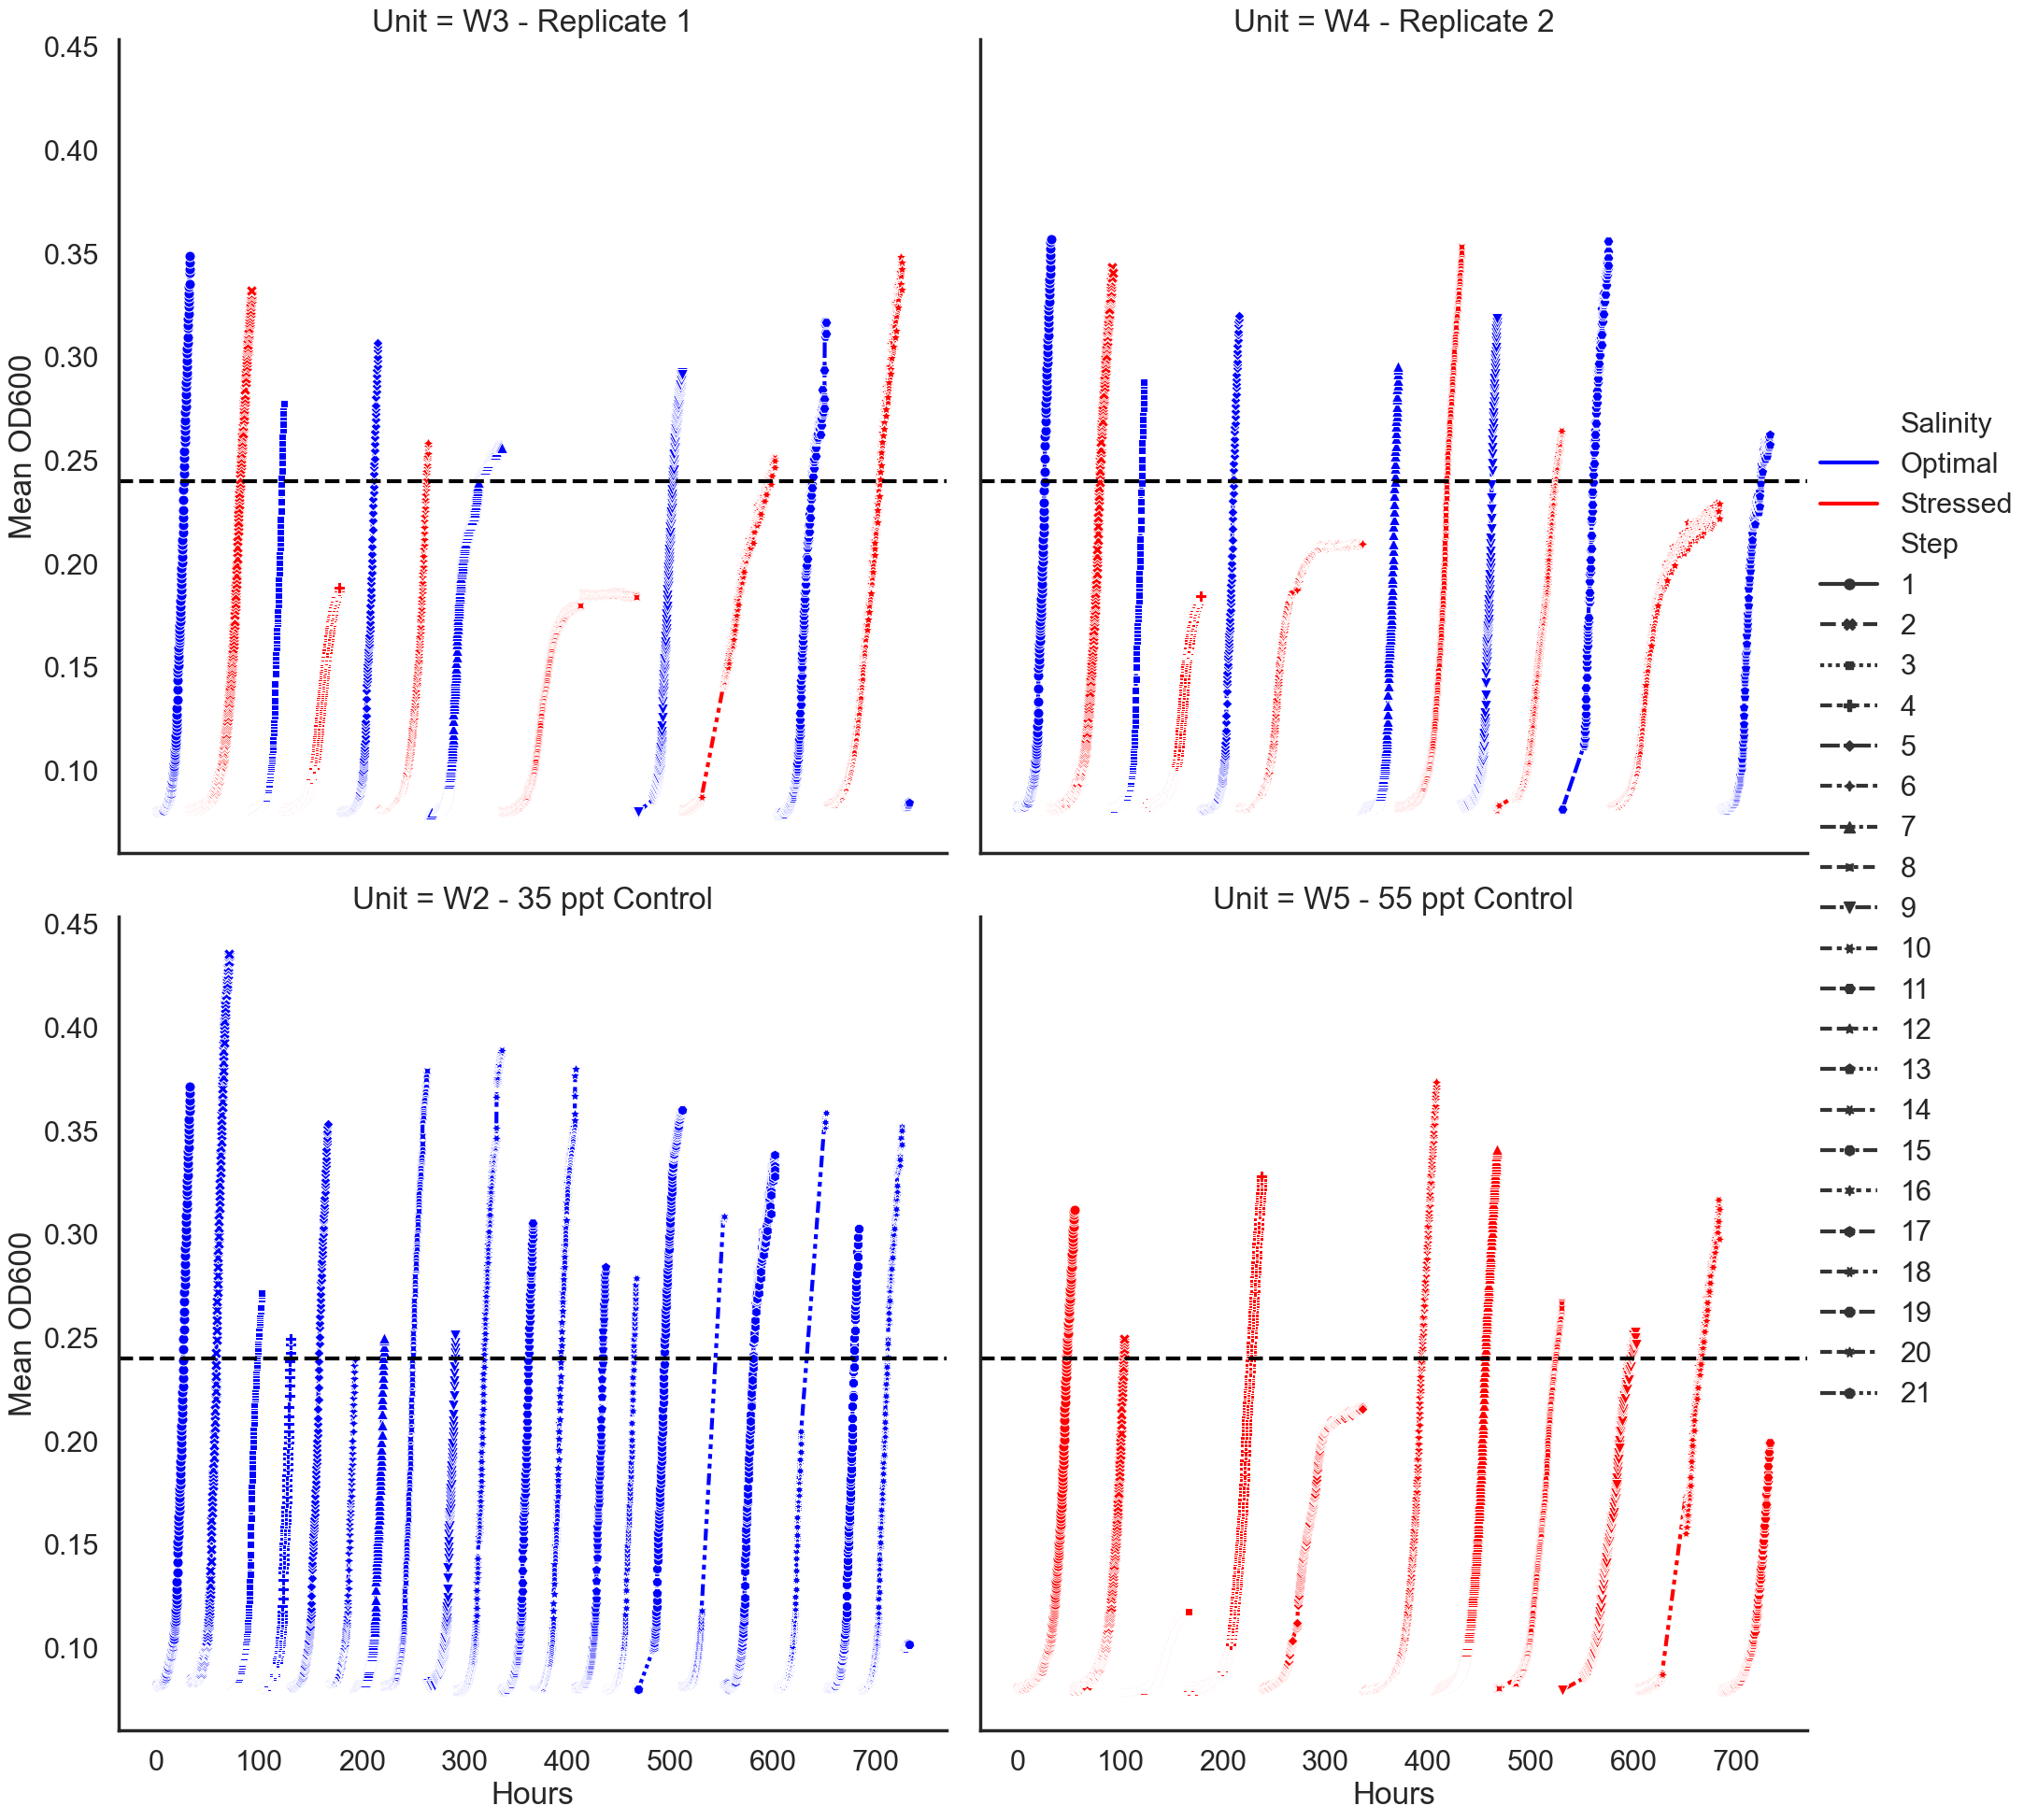

In [6]:
# # Take a rolling average in each step
# df = df.with_columns(pl.col("Time").dt.truncate("10m").alias("Time"))
# df = df.group_by("Unit", "Time", "Salinity", "Step").agg(pl.col("OD600").mean().alias("Mean OD600"))
# df = df.with_columns((pl.col("Time").sub(pl.col("Time").min()).dt.total_seconds()/3600).alias("Hours"))

# # Plotting the growth curves using the new 'Transformed OD' column
# col_order = ["W3 - Replicate 1", "W4 - Replicate 2", "W2 - 35 ppt Control", "W5 - 55 ppt Control"]
# g = sns.relplot(x="Hours", y="Mean OD600", hue="Salinity", style="Step", col="Unit", col_wrap=2, col_order=col_order, height=10, markers=True,
#              markersize=8, data=df.collect(streaming=True).to_pandas(), kind="line", hue_order=["Optimal", "Stressed"], palette=["blue", "red"])

# for ax in g.axes.flatten():
#     ax.axhline(y=threshold_od, color='black', linestyle='--')

# plt.show()

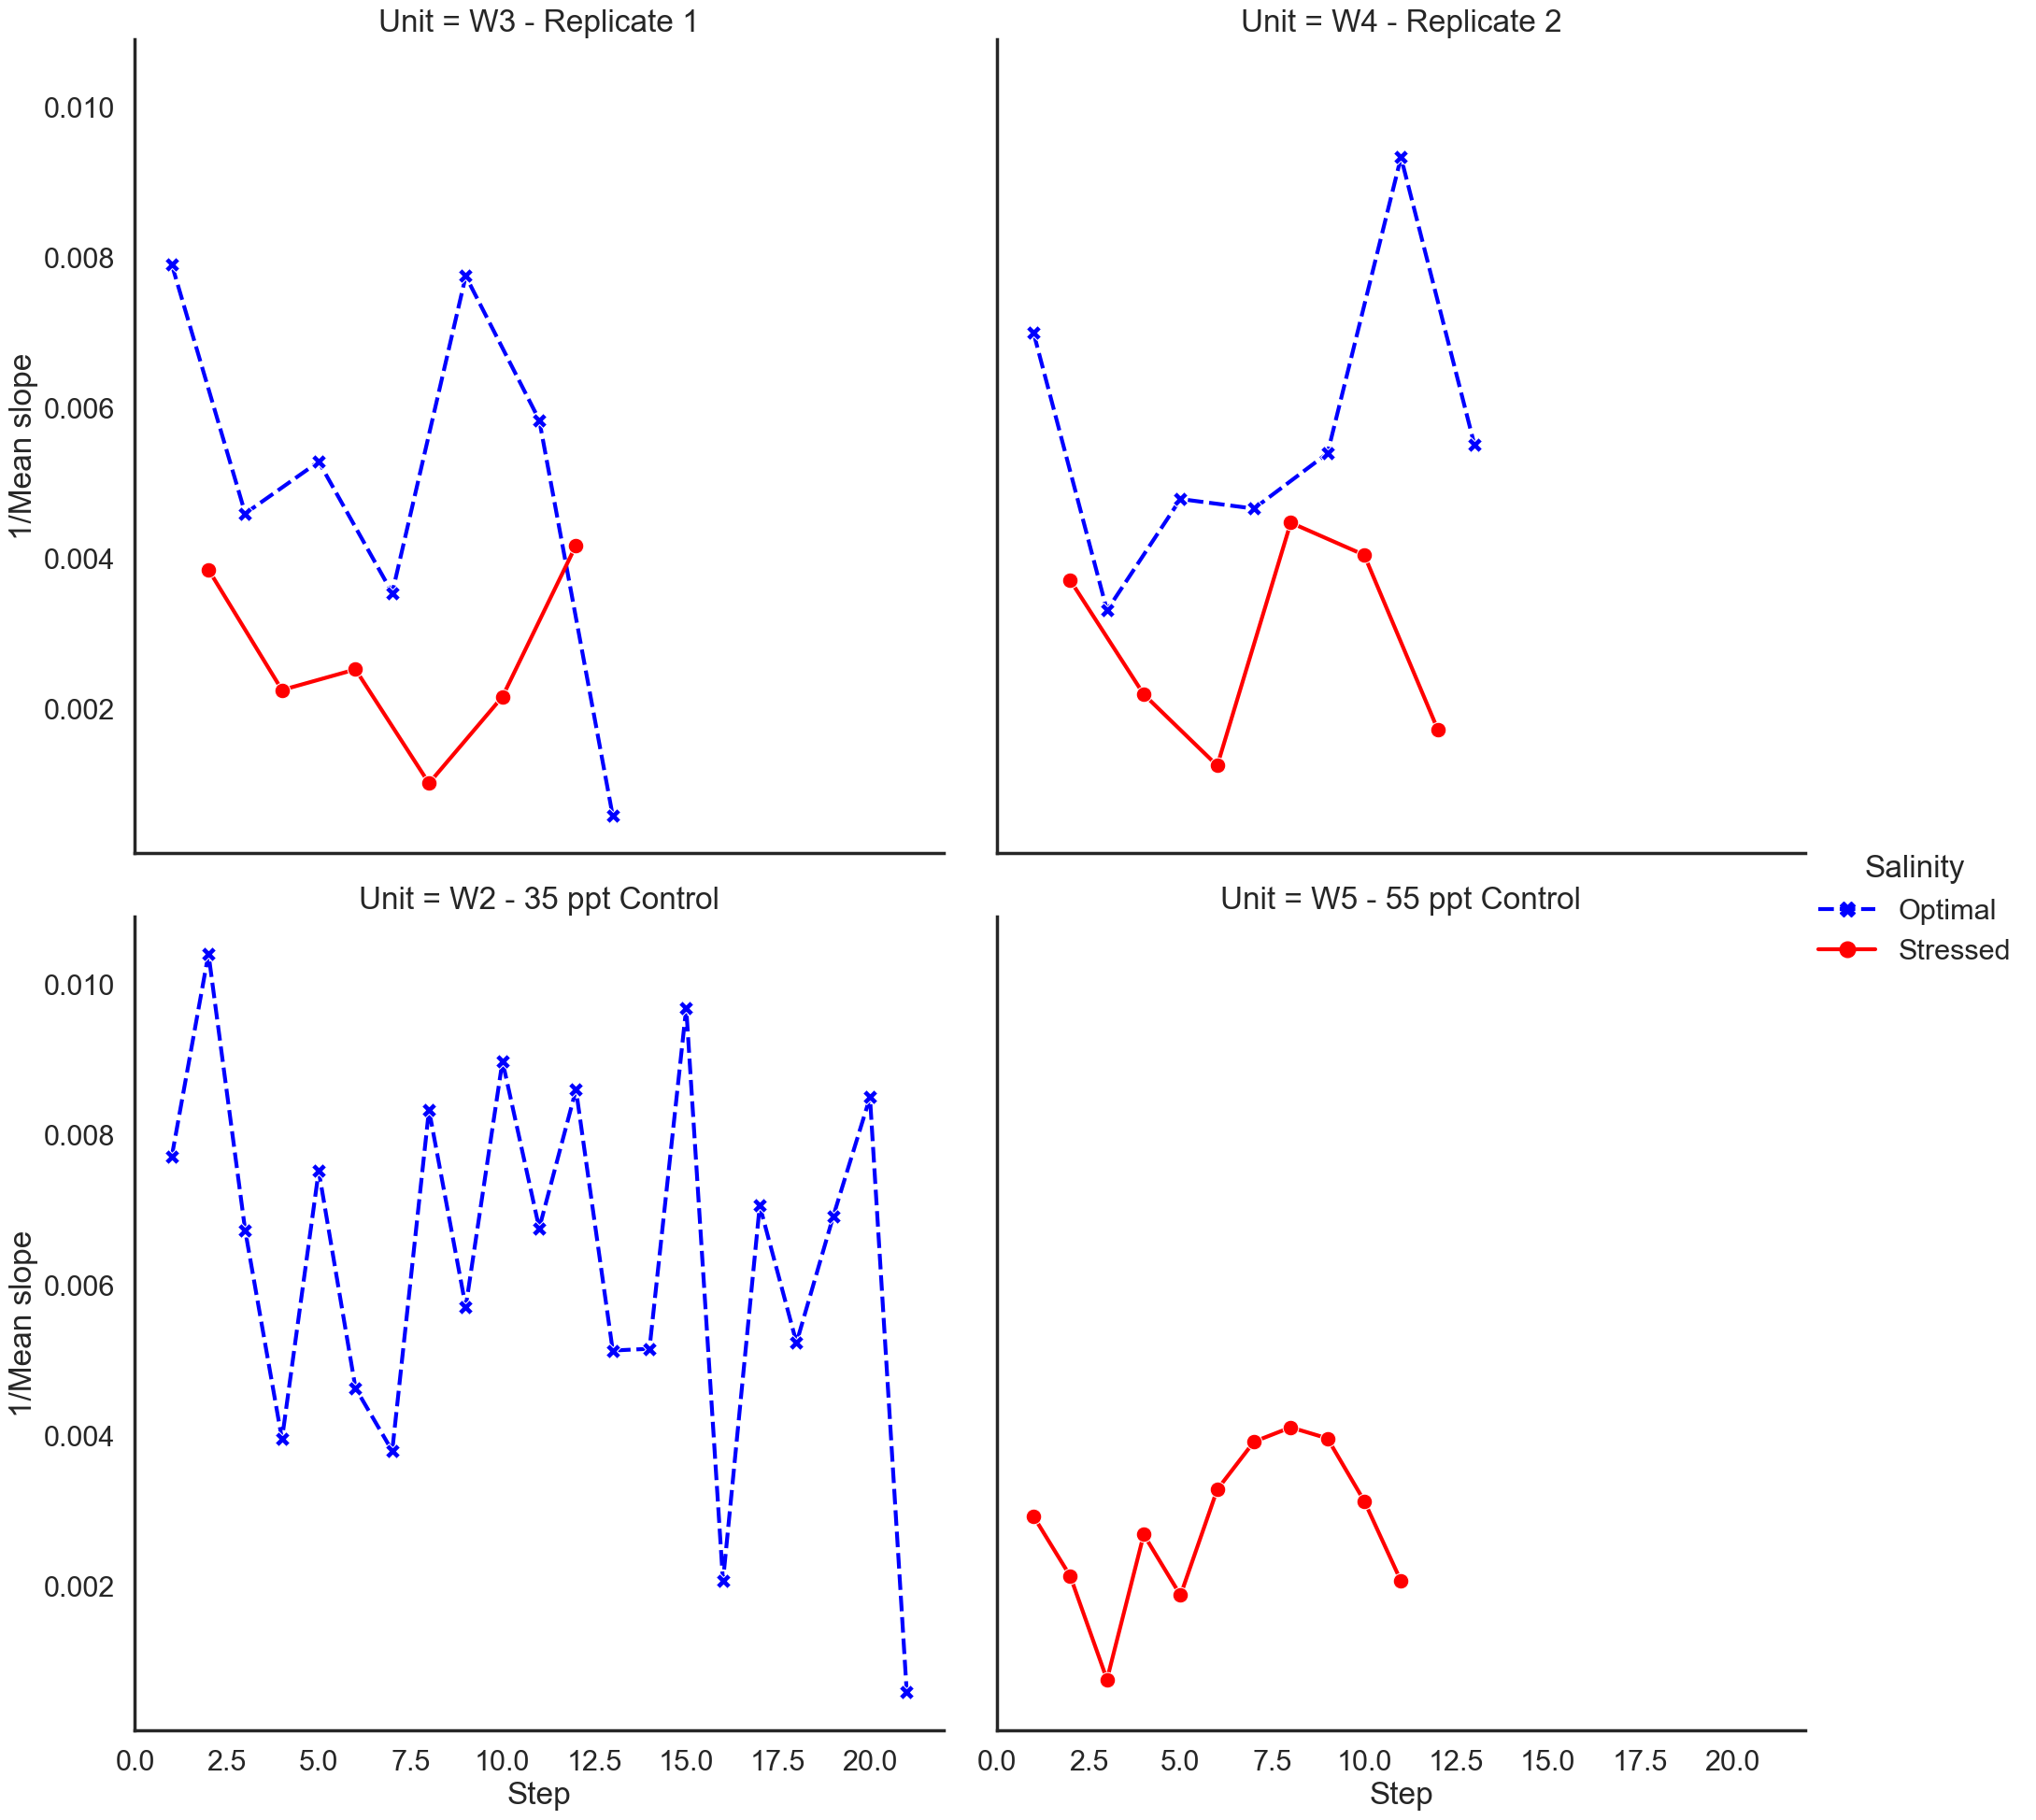

In [7]:
# # Get max slopes
# max_slopes = df.with_columns(pl.col("Hours").least_squares.rolling_ols("Mean OD600",
#                                            window_size=6,
#                                            mode="coefficients",
#                                            add_intercept=True,
#                                           ).over("Unit", "Step").alias("slopes"))
# max_slopes = max_slopes.with_columns(pl.col("slopes").struct[0].alias("slopes"))

# max_slopes = max_slopes.group_by("Unit", "Step", "Salinity").agg(pl.col("slopes").mean().alias("Mean slope"))
# max_slopes = max_slopes.with_columns(pl.lit(1).truediv(pl.col("Mean slope")).alias("1/Mean slope"))

# # Plot
# sns.relplot(x="Step", y="1/Mean slope", hue="Salinity", col="Unit", col_wrap=2, style="Salinity", col_order=col_order, height=10, markers=True,
#             data=max_slopes.collect(streaming=True).to_pandas(), kind="line", hue_order=["Optimal", "Stressed"], palette=["blue", "red"])

In [8]:
# # predict_od = 0.45
# plot_df = {"Pioreactor": [], "Time (h)": []}
# pioreactors = equations.keys()
# for pioreactor in pioreactors:
#     pio_df = df.filter(pl.col("Unit").eq(pioreactor)).sort("Time", descending=False)

#     steps = pio_df.get_column("Step").sort().unique().to_list()
#     current_od = pio_df.filter(pl.col("Step").eq(steps[-1])).get_column("OD600")[-1]
    
#     last_step = pio_df.filter(pl.col("Step").eq(steps[-3]))
#     thresh_time = (last_step.with_columns((pl.col("OD600") - predict_od).abs().alias("distance"))
#                         .filter(pl.col("distance") == pl.col("distance").min())
#                         .get_column("Time")[0])
    
#     time_in_last_step = (last_step.with_columns((pl.col("OD600") - current_od).abs().alias("distance"))
#                         .filter(pl.col("distance") == pl.col("distance").min())
#                         .get_column("Time")[0])
    
#     time_to_threshold = (thresh_time - time_in_last_step).total_seconds() / 3600

#     #Add time to threshold to latest timestamp of current step
#     predicted_time_at_threshold = pio_df.filter(pl.col("Step").eq(steps[-1])).get_column("Time")[-1] + (thresh_time - time_in_last_step)
    
#     print(f"Predicted time to {predict_od:.2f} for {pioreactor}: {predicted_time_at_threshold}")


AttributeError: 'LazyFrame' object has no attribute 'get_column'